In [1]:
# Standard imports
from pathlib import Path
import pandas as pd
import numpy as np

# Import our refactored modules
from athletes_brain.fig1 import (
    Fig1Config,
    AthletesBrainDataLoader,
    GroupComparison,
    BrainPlotter,
    generate_figure1,
)

# Import specific functions for focused analysis
from athletes_brain.fig1.main import analyze_specific_comparison, get_most_significant_regions

2025-08-24 16:06:31.775 | INFO     | athletes_brain.config:<module>:11 - PROJ_ROOT path is: /home/galkepler/Projects/athletes_brain


In [2]:
# Initialize configuration
config = Fig1Config()

config.METRICS = ["gm_vol", "adc"]
# Set up matplotlib configuration for consistent plots
config.setup_matplotlib_config()

# Display configuration
print(f"Atlas: {config.ATLAS}")
print(f"Metrics: {config.METRICS}")
print(
    f"Group labels: {config.CLIMBER_GROUP_LABEL}, {config.BJJ_GROUP_LABEL}, {config.CONTROL_GROUP_LABEL}"
)
print(f"P-value threshold: {config.P_THRESHOLD}")
print(f"Visualization range: [{config.VMIN}, {config.VMAX}]")

Atlas: schaefer2018tian2020_400_7
Metrics: ['gm_vol', 'adc']
Group labels: Climbing, Bjj, Control
P-value threshold: 0.05
Visualization range: [-5, 5]


In [3]:
# Generate complete Figure 1
output_dir = Path("/media/storage/phd") / "athletes_brain" / "figures" / "learners"
# generate_figure1(output_dir=output_dir, config=config)

In [4]:
# Initialize data loader
data_loader = AthletesBrainDataLoader(config)

# Load all data
metric_data, parcels, nifti_path, nifti_matlab_path = data_loader.load_all_data()

print(f"Loaded {len(metric_data)} metrics")
print(f"Loaded {len(parcels)} brain parcels")
print(f"Metrics: {list(metric_data.keys())}")

# metric_data = {key: val[val["cs_valid"]] for key, val in metric_data.items()}

# Display sample data (demographics)
d = metric_data["gm_vol"].drop_duplicates(subset=["subject_code"], keep="first")
print(f"Total N participants: {d.shape[0]}")
athletes = d[d["target"]]
climbers = athletes[athletes["group"] == config.CLIMBER_GROUP_LABEL]
bjjers = athletes[athletes["group"] == config.BJJ_GROUP_LABEL]

learners = d[d["learner"]]
climbers_learners = learners[learners["group"] == config.CLIMBER_GROUP_LABEL]
bjjers_learners = learners[learners["group"] == config.BJJ_GROUP_LABEL]

print(f"Total N athletes: {athletes.shape[0]}")
print(f"Total N climbers: {climbers.shape[0]}")
print(f"Total N BJJ practitioners: {bjjers.shape[0]}")
print(f"Total N learners: {learners.shape[0]}")
print(f"Total N climbers (learners): {climbers_learners.shape[0]}")
print(f"Total N BJJ practitioners (learners): {bjjers_learners.shape[0]}")

2025-08-24 16:06:46.780 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:48 - Loading metric data...
2025-08-24 16:06:46.780 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:54 - Loading gm_vol data


/home/galkepler/Projects/athletes_brain/athletes_brain/fig1/data_loader.py:57: DtypeWarning: Columns (1,6,7,8,9,10,11,12,68,74,78,79,80,81,82,84,85,86,87,92,93,94,95,96,97,99,113,116,121,122,123,124,125,132,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.processed_dir / f"{metric}.csv", index_col=0).reset_index(


2025-08-24 16:06:55.728 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:82 - Loaded 771800 records for gm_vol
2025-08-24 16:06:55.728 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:54 - Loading adc data


/home/galkepler/Projects/athletes_brain/athletes_brain/fig1/data_loader.py:57: DtypeWarning: Columns (16,23,24,25,26,27,33,39,43,44,45,46,47,49,50,51,52,57,58,59,60,61,62,64,78,81,86,87,88,89,96,97,98,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.processed_dir / f"{metric}.csv", index_col=0).reset_index(


2025-08-24 16:07:02.009 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:82 - Loaded 766352 records for adc
2025-08-24 16:07:02.009 | SUCCESS  | athletes_brain.fig1.data_loader:load_metric_data:84 - Successfully loaded 2 metrics
2025-08-24 16:07:02.009 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:32 - Loading atlas data for schaefer2018tian2020_400_7
2025-08-24 16:07:02.011 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:39 - Loaded 454 parcels from atlas
Loaded 2 metrics
Loaded 454 brain parcels
Metrics: ['gm_vol', 'adc']
Total N participants: 1266
Total N athletes: 132
Total N climbers: 75
Total N BJJ practitioners: 49
Total N learners: 240
Total N climbers (learners): 116
Total N BJJ practitioners (learners): 100


In [8]:
for _, df in metric_data.items():
    df["timestamp"] = pd.to_datetime(df["session_id"], format="%Y%m%d%H%M")


In [12]:
for metric, df in metric_data.items():
    bjj_data = df[df["group"] == config.BJJ_GROUP_LABEL].drop(columns=["target","learner","cs_valid"])
    bjj_data.to_csv(output_dir / f"{metric}_bjj_data.csv", index=False)
    climbers_data = df[df["group"] == config.CLIMBER_GROUP_LABEL].drop(columns=["target","learner","cs_valid"])
    climbers_data.to_csv(output_dir / f"{metric}_climbers_data.csv", index=False)
    # break
# bjj_data

In [319]:
import math
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from numpy.linalg import LinAlgError
from tqdm import tqdm

# ---------- helpers ----------
def norm_ccdf(z):
    return 2 * 0.5 * math.erfc(abs(z) / math.sqrt(2))

def lincom(res, coefs):
    """Linear combo on statsmodels result."""
    P = res.params
    V = res.cov_params()
    L = np.zeros(len(P))
    for name, w in coefs.items():
        # print(P)
        if name in P.index:
            L[P.index.get_loc(name)] = w
    est = float(L @ P)
    var = float(L @ V.values @ L)
    se  = math.sqrt(max(var, 0.0))
    z   = est / se if se > 0 else np.nan
    p   = norm_ccdf(z) if se > 0 else np.nan
    lo, hi = est - 1.96*se, est + 1.96*se
    return est, se, z, p, lo, hi

def _sex_term(d):
    return " + C(sex)" if ("sex" in d.columns and d["sex"].nunique() > 1) else ""

def _tiv_term(metric: str):
    return " + tiv" if "vol" in str(metric).lower() else ""

def add_scaled_covariates(d: pd.DataFrame, metric: str) -> pd.DataFrame:
    d = d.copy()
    # Age: center, then square the centered term
    if "age_at_scan" in d.columns:
        d["age_c"]  = d["age_at_scan"] - d["age_at_scan"].mean()
        d["age_c2"] = d["age_c"] ** 2
    else:
        d["age_c"] = d["age_c2"] = 0.0

    # TIV: z-score if present and used for 'vol' metrics
    if "tiv" in d.columns and "vol" in str(metric).lower():
        sd = d["tiv"].std(ddof=0)
        d["tiv_z"] = (d["tiv"] - d["tiv"].mean()) / (sd if sd and sd > 0 else 1.0)
    # else:
    #     d["tiv_z"] = 0.0

    return d


# ---------- primary Athlete vs Learner model ----------
def fit_roi_model(d, metric:str, time_variable:str="time_months"):
    d = add_scaled_covariates(d, metric)
    d["tp_label"]  = pd.Categorical(d["tp_label"], categories=["pre","post"])
    d["condition"] = pd.Categorical(d["condition"], categories=["Athlete","Learner"])
    if "sex" in d:
        d["sex"] = d["sex"].astype("category")

    if d["condition"].nunique() < 2:
        return None, "one_group_only"
    if d["subject_code"].nunique() < 3:
        return None, "too_few_subjects"

    sex_term = " + C(sex)" if ("sex" in d and d["sex"].nunique() > 1) else ""
    tiv_term = " + tiv_z"  if ("vol" in str(metric).lower()) else ""

    formula = (
        f"y ~ {time_variable} * C(condition, levels=['Athlete','Learner'])"
        " + age_c + age_c2" + sex_term + tiv_term
    )
    try:
        m = smf.mixedlm(formula, data=d, groups=d["subject_code"]).fit(reml=True, maxiter=int(1e6))
        return m, "mixed"
    except (LinAlgError, ValueError):
        return None, "mixed_fail"
    # except (LinAlgError, ValueError):
    #     ols = smf.ols(formula, data=d).fit()
    #     return ols.get_robustcov_results(cov_type="cluster", groups=d["subject_code"]), "ols_cluster"


def extract_effects(res, time_variable:str = "time_months"):
    """Key effects with Athlete baseline."""
    is_mixed = hasattr(res, "random_effects") or hasattr(res, "cov_re")
    # p_post   = "C(tp_label, levels=['pre', 'post'])[T.post]"
    p_post = time_variable
    p_L      = "C(condition, levels=['Athlete', 'Learner'])[T.Learner]"
    p_postxL = p_post + ":" + p_L

    out = {}
    est, se, z, p, lo, hi = lincom(res, {p_post: 1.0})
    out.update(dict(beta_post=est, se_post=se, z_post=z, p_post=p, lo_post=lo, hi_post=hi))

    est, se, z, p, lo, hi = lincom(res, {p_L: 1.0})
    out.update(dict(beta_learner_pre=est, se_learner_pre=se, z_learner_pre=z, p_learner_pre=p,
                    lo_learner_pre=lo, hi_learner_pre=hi))

    est, se, z, p, lo, hi = lincom(res, {p_postxL: 1.0})
    out.update(dict(beta_postx_learner=est, se_postx_learner=se, z_postx_learner=z,
                    p_postx_learner=p, lo_postx_learner=lo, hi_postx_learner=hi))

    est, se, z, p, lo, hi = lincom(res, {p_post: 1.0, p_postxL: 1.0})
    out.update(dict(beta_learner_post_change=est, se_learner_post_change=se,
                    p_learner_post_change=p, lo_learner_post_change=lo, hi_learner_post_change=hi))

    out["model"] = "mixed" if is_mixed else "ols_cluster"
    out["converged"] = getattr(res, "converged", np.nan)
    return out

# ---------- learners-only: pre/post model ----------
def fit_learners_prepost(d, metric:str):
    dl = d.query("condition == 'Learner' and tp_label in ['pre', 'post']").copy()
    has_both = dl.groupby("subject_code")["tp_label"].transform(lambda s: {"pre","post"}.issubset(set(s)))
    dl = dl[has_both]
    if dl["subject_code"].nunique() < 2:
        return None, "L_too_few_subjects"

    dl = add_scaled_covariates(dl, metric)
    if "sex" in dl: dl["sex"] = dl["sex"].astype("category")
    formula = "y ~ C(tp_label, levels=['pre', 'post']) + age_c + age_c2" \
              + (" + C(sex)" if ("sex" in dl and dl["sex"].nunique()>1) else "") \
              + (" + tiv_z" if ("vol" in str(metric).lower()) else "")
    try:
        m = smf.mixedlm(formula, data=dl, groups=dl["subject_code"]).fit(reml=True, maxiter=int(1e6))
        status = "L_mixed"
    except (LinAlgError, ValueError):
        m = smf.ols(formula, data=dl).fit().get_robustcov_results(cov_type="cluster", groups=dl["subject_code"])
        status = "L_ols_cluster"
    
    # extract the pre→post effect within learners
    term = "C(tp_label, levels=['pre', 'post'])[T.post]"
    est, se, z, p, lo, hi = lincom(m, {term: 1.0})
    out = {
        "L_post_beta": est, "L_post_se": se, "L_post_z": z, "L_post_p": p,
        "L_post_lo": lo, "L_post_hi": hi,
        "L_model": "mixed" if status == "L_mixed" else "ols_cluster",
        "L_status": status
    }
    return out, status

# ---------- learners-only: monthly slope model ----------
def fit_learners_slope(d, metric:str, time_variable:str="time_months"):
    dl = d.query("condition == 'Learner' and tp_label in ['pre', 'post']").copy()
    has_both = dl.groupby("subject_code")["tp_label"].transform(lambda s: {"pre","post"}.issubset(set(s)))
    dl = dl[has_both]
    if dl["subject_code"].nunique() < 2: return None, "Lsl_too_few_subjects"

    dl = add_scaled_covariates(dl, metric)
    if "sex" in dl: dl["sex"] = dl["sex"].astype("category")
    formula = f"y ~ {time_variable} + age_c + age_c2" \
              + (" + C(sex)" if ("sex" in dl and dl["sex"].nunique()>1) else "") \
              + (" + tiv_z" if ("vol" in str(metric).lower()) else "")
    try:
        m = smf.mixedlm(formula, data=dl, groups=dl["subject_code"]).fit(reml=True, maxiter=int(1e6))
        status = "Lsl_mixed"
    except (LinAlgError, ValueError):
        m = smf.ols(formula, data=dl).fit().get_robustcov_results(cov_type="cluster", groups=dl["subject_code"])
        status = "Lsl_ols_cluster"
    # extract time_months effect as before...


    term = time_variable
    est, se, z, p, lo, hi = lincom(m, {term: 1.0})
    out = {
        "L_slope_month_beta": est, "L_slope_month_se": se, "L_slope_month_z": z,
        "L_slope_month_p": p, "L_slope_month_lo": lo, "L_slope_month_hi": hi,
        "L_slope_model": "mixed" if status == "Lsl_mixed" else "ols_cluster",
        "L_slope_status": status
    }
    return out, status

In [320]:
def fit_roi_model_both(d, metric: str):
    results = {}
    d = add_scaled_covariates(d, metric)
    d["tp_label"] = pd.Categorical(d["tp_label"], categories=["pre", "post"])
    d["condition"] = pd.Categorical(d["condition"], categories=["Athlete", "Learner"])
    if "sex" in d: d["sex"] = d["sex"].astype("category")
    sex_term = " + C(sex)" if ("sex" in d and d["sex"].nunique() > 1) else ""
    tiv_term = " + tiv_z" if ("vol" in str(metric).lower()) else ""

    if d["condition"].nunique() < 2:
        return {"status_slope": "one_group_only", "status_factor": "one_group_only"}
    if d["subject_code"].nunique() < 3:
        return {"status_slope": "too_few_subjects", "status_factor": "too_few_subjects"}
    
    # --- 1. Time as Slope ---
    formula_slope = (
        "y ~ time_months * C(condition, levels=['Athlete','Learner'])"
        " + age_c + age_c2" + sex_term + tiv_term
    )
    try:
        m_slope = smf.mixedlm(formula_slope, data=d, groups=d["subject_code"]).fit(reml=True, maxiter=int(1e6))
        results["model_slope"] = m_slope
        results["status_slope"] = "mixed"
    except (LinAlgError, ValueError):
        results["model_slope"] = None
        results["status_slope"] = "mixed_fail"
    
    # --- 2. Time as Factor ---
    formula_factor = (
        "y ~ C(tp_label, levels=['pre', 'post']) * C(condition, levels=['Athlete','Learner'])"
        " + age_c + age_c2" + sex_term + tiv_term
    )
    try:
        m_factor = smf.mixedlm(formula_factor, data=d, groups=d["subject_code"]).fit(reml=True, maxiter=int(1e6))
        results["model_factor"] = m_factor
        results["status_factor"] = "mixed"
    except (LinAlgError, ValueError):
        results["model_factor"] = None
        results["status_factor"] = "mixed_fail"
    # return d, formula_factor

    return results


def extract_effects_both(model_slope, model_factor):
    out = {}
    # -- Slope model
    if model_slope is not None:
        # Main effect of time (slope): 'time_months'
        out.update({f'slope_{k}': v for k, v in zip(
            ["est", "se", "z", "p", "lo", "hi"],
            lincom(model_slope, {"time_months": 1.0})
        )})
        out.update({f'slope_interaction_{k}': v for k, v in zip(
            ["est", "se", "z", "p", "lo", "hi"],
            lincom(model_slope, {"time_months:C(condition, levels=['Athlete', 'Learner'])[T.Learner]": 1.0})
        )})
        # Interaction slope x learner
        out.update({f'slope_x_learner_{k}': v for k, v in zip(
            ["est", "se", "z", "p", "lo", "hi"],
            lincom(model_slope, {
                "time_months": 1.0, 
                "time_months:C(condition, levels=['Athlete', 'Learner'])[T.Learner]": 1.0
            })
        )})
    # -- Factor model
    if model_factor is not None:
        out.update({f'factor_{k}': v for k, v in zip(
            ["est", "se", "z", "p", "lo", "hi"],
            lincom(model_factor, {"C(tp_label, levels=['pre', 'post'])[T.post]": 1.0})
        )})
        out.update({f'factor_interaction_{k}': v for k, v in zip(
            ["est", "se", "z", "p", "lo", "hi"],
            lincom(model_factor, {"C(tp_label, levels=['pre', 'post'])[T.post]:C(condition, levels=['Athlete', 'Learner'])[T.Learner]": 1.0})
        )})
        out.update({f'factor_x_learner_{k}': v for k, v in zip(
            ["est", "se", "z", "p", "lo", "hi"],
            lincom(model_factor, {
                "C(tp_label, levels=['pre', 'post'])[T.post]": 1.0,
                "C(tp_label, levels=['pre', 'post'])[T.post]:C(condition, levels=['Athlete', 'Learner'])[T.Learner]": 1.0
            })
        )})
    return out


In [ ]:
# ---------- your existing prep ----------
from notebooks.learners.roi_prep import (
    PrepConfig, prepare_roi_longitudinal, prepost_ancova_table, delta_change_table
)

cfg = PrepConfig(restrict_roles=False, min_scans_per_subject=1)

# Columns to store (primary + learners-only)
add_cols = [
    'n_subjects', 'n_athlete', 'n_learner', 'n_pairs_athlete',
       'n_pairs_learner', 'L_model', 'L_status', 'L_slope_model',
       'L_slope_status', 'status_slope', 'status_factor', 'slope_est',
       'slope_se', 'slope_z', 'slope_p', 'slope_lo', 'slope_hi',
       'slope_x_learner_est', 'slope_x_learner_se', 'slope_x_learner_z',
       'slope_x_learner_p', 'slope_x_learner_lo', 'slope_x_learner_hi',
       'factor_est', 'factor_se', 'factor_z', 'factor_p', 'factor_lo',
       'factor_hi', 'factor_x_learner_est', 'factor_x_learner_se',
       'factor_x_learner_z', 'factor_x_learner_p', 'factor_x_learner_lo',
       'factor_x_learner_hi', 'slope_interaction_est', 'slope_interaction_se',
       'slope_interaction_z', 'slope_interaction_p', 'slope_interaction_lo',
       'slope_interaction_hi', 'factor_interaction_est',
       'factor_interaction_se', 'factor_interaction_z', 'factor_interaction_p',
       'factor_interaction_lo', 'factor_interaction_hi', 'L_post_beta',
       'L_post_se', 'L_post_z', 'L_post_p', 'L_post_lo', 'L_post_hi',
       'L_slope_month_beta', 'L_slope_month_se', 'L_slope_month_z',
       'L_slope_month_p', 'L_slope_month_lo', 'L_slope_month_hi'
]

results = {}
all_rows = []

FORCE = False

for metric, df in metric_data.items():
    # if metric != "adc":
    #     continue
    for group in ["all", "Climbing", "Bjj"]:
        data_destination = output_dir / group / metric / "stats.csv"
        data_destination.parent.mkdir(parents=True, exist_ok=True)
        if not FORCE and data_destination.exists():
            stats = pd.read_csv(data_destination)
            continue

        # if group != "Climbing":
        #     continue
        if group != "all":
            group_df = df[df["group"] == group]
        else:
            group_df = df.copy()
        stats = parcels.copy()
        for c in add_cols:
            if c not in stats.columns:
                stats[c] = np.nan

        for i, prow in tqdm(parcels.iterrows(), total=parcels.shape[0], desc=f"{metric} · {group}"):
            # if i != 174:
            #     continue
            region = prow["index"]
            roi_df = group_df[group_df["index"] == region]
            tidy = prepare_roi_longitudinal(roi_df, cfg)
            tidy = tidy[tidy["time_months"] < 12*2]
            # --- keep only pre/post; keep subjects that have BOTH pre & post
            d = tidy.loc[tidy["tp_label"].isin(["pre", "post"])].copy()
            d = d.loc[tidy["sport"].str.lower().isin(["bjj", "climbing"])].copy()
            if d.empty:
                stats.loc[i, "status"] = "no_pairs"
                continue

            # counts
            n_sub = d["subject_code"].nunique()
            n_by_cond = d.groupby("condition")["subject_code"].nunique() if not d.empty else pd.Series(dtype=int)
            n_learn   = int(n_by_cond.get("Learner", 0))
            n_ath     = int(n_by_cond.get("Athlete", 0))

            # pairs by condition (subjects with both labels)
            both = d.groupby(["subject_code","condition"])["tp_label"].nunique().reset_index(name="n")
            n_pairs_ath     = int((both.query("condition=='Athlete' and n==2")["subject_code"]).nunique())
            n_pairs_learner = int((both.query("condition=='Learner' and n==2")["subject_code"]).nunique())

            # compute change scores (delta metric)
            has_both = d.groupby("subject_code")["tp_label"].transform(lambda s: {"pre","post"}.issubset(set(s)))
            d_both = d[has_both].copy()
            d_before = d_both[d_both["tp_label"] == "pre"]
            d_after = d_both[d_both["tp_label"] == "post"]
            df_diff = d_after.copy()
            df_diff["delta"] = df_diff["y"] - d_before["y"].values
            df_diff["relative_delta"] = df_diff["delta"] / d_before["y"].values
            df_diff["delta_days"] = (d_after["scan_dt"] - d_before["scan_dt"].values).dt.days
            
            stats.loc[i, ["n_subjects","n_learner","n_athlete","n_pairs_learner","n_pairs_athlete"]] = \
                [n_sub, n_learn, n_ath, n_pairs_learner, n_pairs_ath]

            # ----- primary Athlete vs Learner model -----
            if n_pairs_ath < 1 or n_pairs_learner < 1:
                stats.loc[i, "status"] = "insufficient_pairs_primary"
            else:
                result_models = fit_roi_model_both(d, metric=metric)
                stats.loc[i, "status_slope"] = result_models.get("status_slope")
                stats.loc[i, "status_factor"] = result_models.get("status_factor")
                out = extract_effects_both(result_models.get("model_slope"), result_models.get("model_factor"))
                for k, v in out.items():
                    stats.loc[i, k] = v

                # res, status = fit_roi_model(d, metric=metric)
                # stats.loc[i, "status"] = status
                # if res is not None:
                #     eff = extract_effects(res)
                #     for k, v in eff.items():
                #         stats.loc[i, k] = v
            # break

            # ----- learners-only pre/post -----
            L_out, L_status = fit_learners_prepost(d, metric=metric)
            if L_out is not None:
                for k, v in L_out.items():
                    stats.loc[i, k] = v
            else:
                stats.loc[i, "L_status"] = L_status

            # ----- learners-only slope (monthly) -----
            Lsl_out, Lsl_status = fit_learners_slope(d, metric=metric)
            if Lsl_out is not None:
                for k, v in Lsl_out.items():
                    stats.loc[i, k] = v
            else:
                stats.loc[i, "L_slope_status"] = Lsl_status
            # if i == 174:
            #     raise ValueError("debug")
            # break
        # break
        # FDR across regions (per metric×group) for key p-values
        for pcol in stats.filter(like="_p").columns:
            qcol = pcol.replace("_p", "_q")
            mask = stats[pcol].notna()
            if mask.any():
                stats.loc[mask, qcol] = multipletests(stats.loc[mask, pcol], method="fdr_bh")[1]

        # annotate and stash
        stats["metric"] = metric
        stats["sport_group"] = group
        stats.to_csv(data_destination, index=False)
        all_rows.append(stats)
        

# Final region-wise table
region_results = pd.concat(all_rows, ignore_index=True)


gm_vol · all:   0%|          | 0/454 [00:00<?, ?it/s]/tmp/ipykernel_2859800/1453138833.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'mixed' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats.loc[i, "status_slope"] = result_models.get("status_slope")
/tmp/ipykernel_2859800/1453138833.py:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'mixed' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats.loc[i, "status_factor"] = result_models.get("status_factor")
/tmp/ipykernel_2859800/1453138833.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'mixed' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats.loc[

PosixPath('/media/storage/phd/athletes_brain/figures/learners')

In [ ]:

# L_out
# stats["L_post_beta"].dropna()
# stats.dropna(axis=1,how="all").columns
# stats.sort_values("factor_interaction_p").head(20)

,index,name,base_name,Label Name,network,component,hemisphere,n_subjects,n_athlete,n_learner,...,factor_interaction_q,L_qost_beta,L_qost_se,L_qost_z,L_qost_q,L_qost_lo,L_qost_hi,L_slope_month_q,metric,sport_group
199,200,7Networks_LH_Default_pCunPCC_11,7networks_lh_default_pcunpcc,7Networks_LH_Default_pCunPCC,default,precuneus posterior cingulate cortex,L,214.0,80.0,134.0,...,0.173758,1.000000,1.0,1.000000,0.665541,-0.921773,1.000000,0.525923,gm_vol,Climbing
281,282,7Networks_RH_DorsAttn_Post_12,7networks_rh_dorsattn_post,7Networks_RH_DorsAttn_Post,dorsal attention,posterior,R,214.0,80.0,134.0,...,0.989785,1.000000,1.0,1.000000,0.792619,-3.612403,1.000000,0.690707,gm_vol,Climbing
47,48,7Networks_LH_SomMot_17,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,214.0,80.0,134.0,...,0.989785,1.000000,1.0,1.000000,0.792619,-1.811787,1.000000,0.657142,gm_vol,Climbing
144,145,7Networks_LH_Cont_pCun_2,7networks_lh_cont_pcun,7Networks_LH_Cont_pCun,control,precuneus,L,214.0,80.0,134.0,...,0.989785,1.000000,1.0,0.879307,0.834121,-4.959647,1.000000,0.884728,gm_vol,Climbing
205,206,7Networks_RH_Vis_6,7networks_rh_vis,7Networks_RH_Vis,visual,visual,R,214.0,80.0,134.0,...,0.989785,-0.617798,1.0,-0.089899,0.989452,-85.822137,1.000000,0.933533,gm_vol,Climbing
130,131,7Networks_LH_Cont_Par_5,7networks_lh_cont_par,7Networks_LH_Cont_Par,control,parietal,L,214.0,80.0,134.0,...,0.989785,-0.950335,1.0,-0.595723,0.910164,-5.235308,1.000000,0.785964,gm_vol,Climbing
433,434,HIP-tail-lh,HIP-tail,Hippocampus tail,subcortex,Hippocampus tail,L,214.0,80.0,134.0,...,0.989785,-3.372272,1.0,-2.968796,0.818458,-7.292028,1.000000,0.840437,gm_vol,Climbing
210,211,7Networks_RH_Vis_11,7networks_rh_vis,7Networks_RH_Vis,visual,visual,R,214.0,80.0,134.0,...,0.989785,1.000000,1.0,0.405407,0.919894,-25.835477,1.000000,0.850155,gm_vol,Climbing
159,160,7Networks_LH_Default_Par_2,7networks_lh_default_par,7Networks_LH_Default_Par,default,parietal,L,214.0,80.0,134.0,...,0.989785,-292.560662,1.0,-1902.126937,0.012681,-146.004292,-882.282638,0.032422,gm_vol,Climbing
270,271,7Networks_RH_DorsAttn_Post_1,7networks_rh_dorsattn_post,7Networks_RH_DorsAttn_Post,dorsal attention,posterior,R,214.0,80.0,134.0,...,0.989785,-6.339646,1.0,-0.534338,0.917753,-198.455439,1.000000,0.925118,gm_vol,Climbing


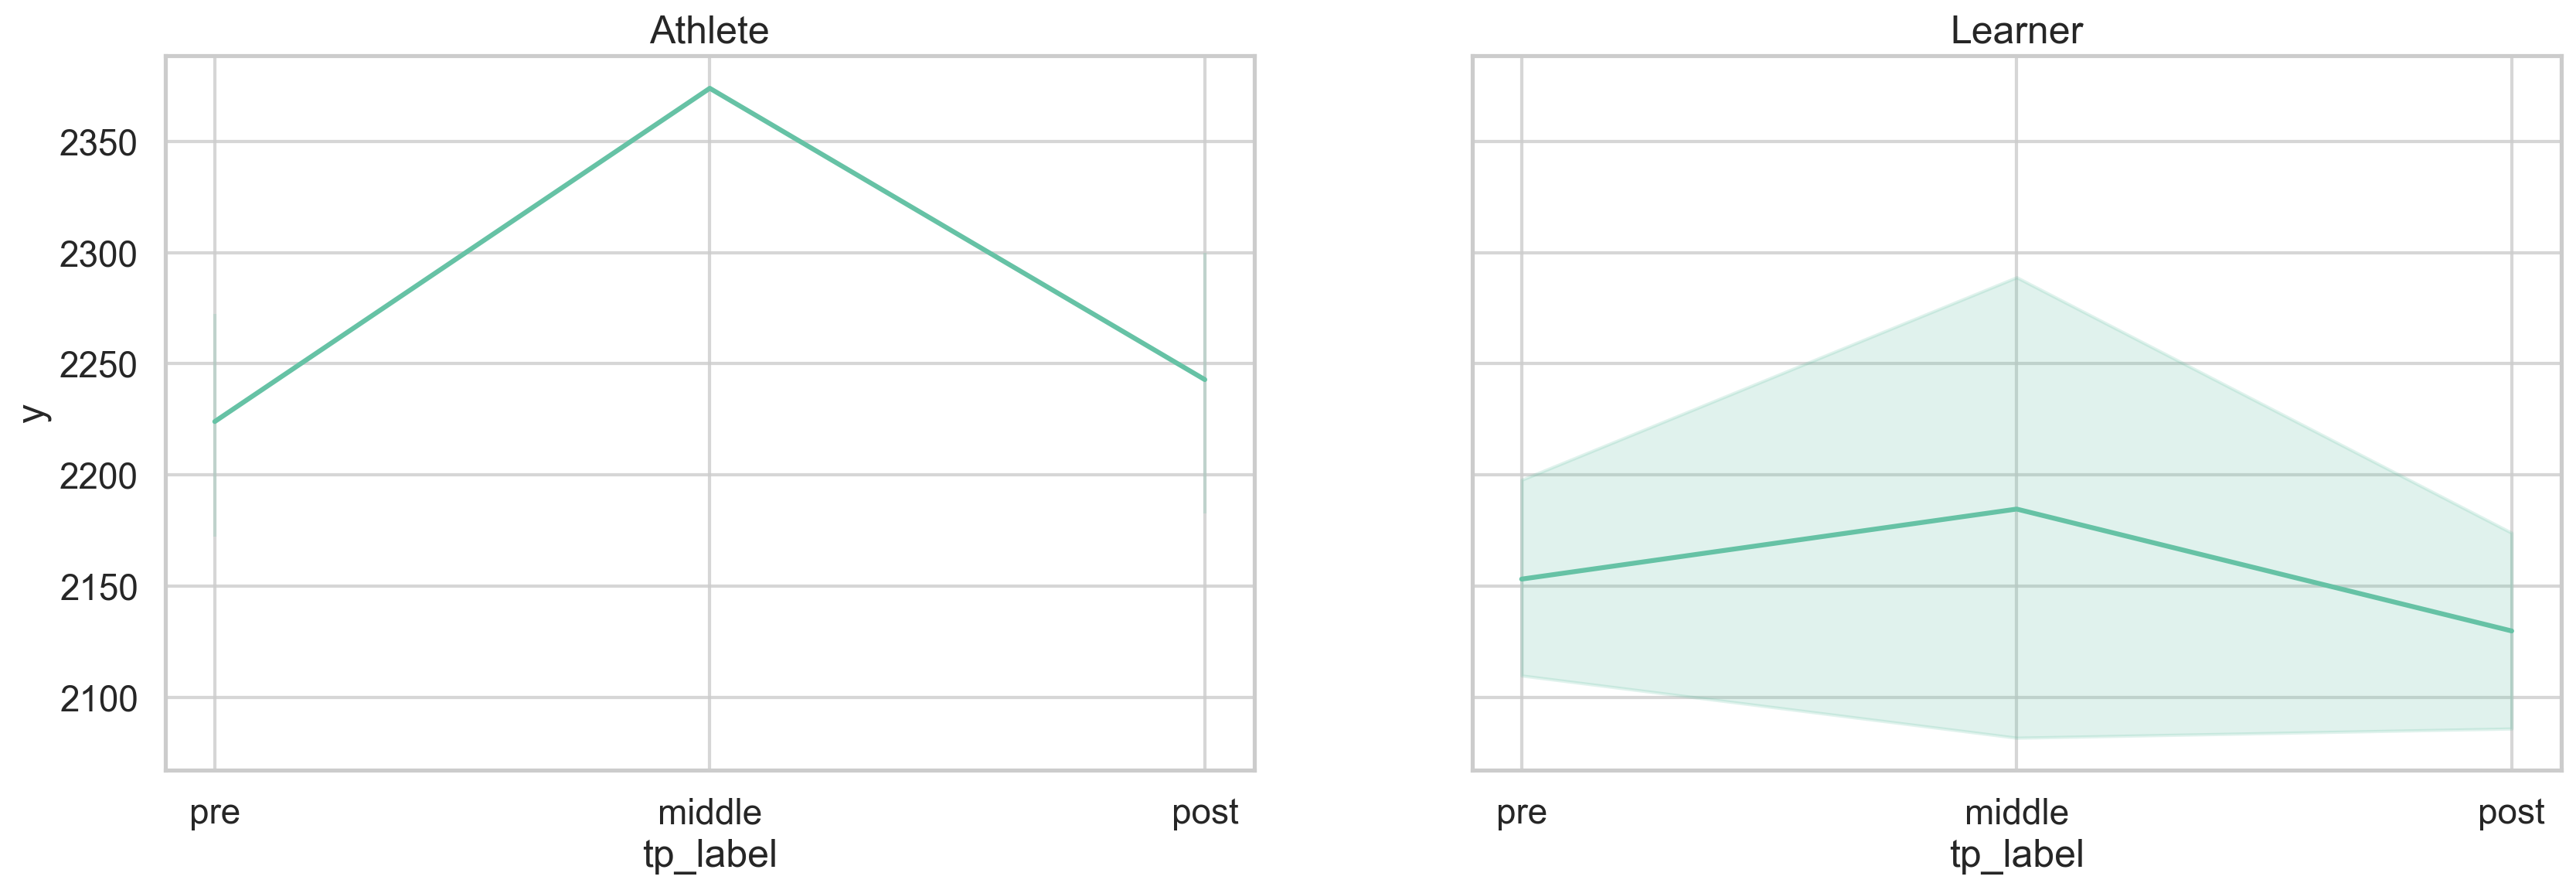

In [277]:
import seaborn as sns
i = stats["factor_x_learner_p"].idxmin()
# i = 125

region = stats.loc[i, "index"]

roi_df = group_df[group_df["index"] == region]
tidy = prepare_roi_longitudinal(roi_df, cfg)
tidy = tidy[tidy["time_months"] < 12*2]
# --- keep only pre/post; keep subjects that have BOTH pre & post
# d = tidy.loc[tidy["tp_label"].isin(["pre", "post"])].copy()
d = tidy.loc[tidy["sport"].str.lower().isin(["bjj", "climbing"])].copy()

# # counts
# n_sub = d["subject_code"].nunique()
# n_by_cond = d.groupby("condition")["subject_code"].nunique() if not d.empty else pd.Series(dtype=int)
# n_learn   = int(n_by_cond.get("Learner", 0))
# n_ath     = int(n_by_cond.get("Athlete", 0))

# # pairs by condition (subjects with both labels)
# both = d.groupby(["subject_code","condition"])["tp_label"].nunique().reset_index(name="n")
# n_pairs_ath     = int((both.query("condition=='Athlete' and n==2")["subject_code"]).nunique())
# n_pairs_learner = int((both.query("condition=='Learner' and n==2")["subject_code"]).nunique())

# # compute change scores (delta metric)
# has_both = d.groupby("subject_code")["tp_label"].transform(lambda s: {"pre","post"}.issubset(set(s)))
# d_both = d[has_both].copy()
# d_before = d_both[d_both["tp_label"] == "pre"]
# d_after = d_both[d_both["tp_label"] == "post"]
# df_diff = d_after.copy()
# df_diff["delta"] = df_diff["y"] - d_before["y"].values
# df_diff["relative_delta"] = df_diff["delta"] / d_before["y"].values
# df_diff["delta_days"] = (d_after["scan_dt"] - d_before["scan_dt"].values).dt.days

# stats.loc[i, ["n_subjects","n_learner","n_athlete","n_pairs_learner","n_pairs_athlete"]] = \
#     [n_sub, n_learn, n_ath, n_pairs_learner, n_pairs_ath]

# # ----- primary Athlete vs Learner model -----
# if n_pairs_ath < 1 or n_pairs_learner < 1:
#     stats.loc[i, "status"] = "insufficient_pairs_primary"
# else:
#     result_models = fit_roi_model_both(d, metric=metric)
#     stats.loc[i, "status_slope"] = result_models.get("status_slope")
#     stats.loc[i, "status_factor"] = result_models.get("status_factor")
#     out = extract_effects_both(result_models.get("model_slope"), result_models.get("model_factor"))
# 2) Keep subjects that have BOTH a pre and a post
# has_both = d.groupby("subject_code")["tp_label"].transform(
#     lambda s: {"pre", "post"}.issubset(set(s))
# )
# d = d[has_both].copy()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(20,6), sharex=True, sharey=True)

for ax,condition in zip(axes, ["Athlete", "Learner"]):
    ax = sns.lineplot(d[d["condition"] == condition], x="tp_label", y="y", ax=ax,
                    #   hue="subject_code", legend=False
                      )
    ax.set_title(condition)

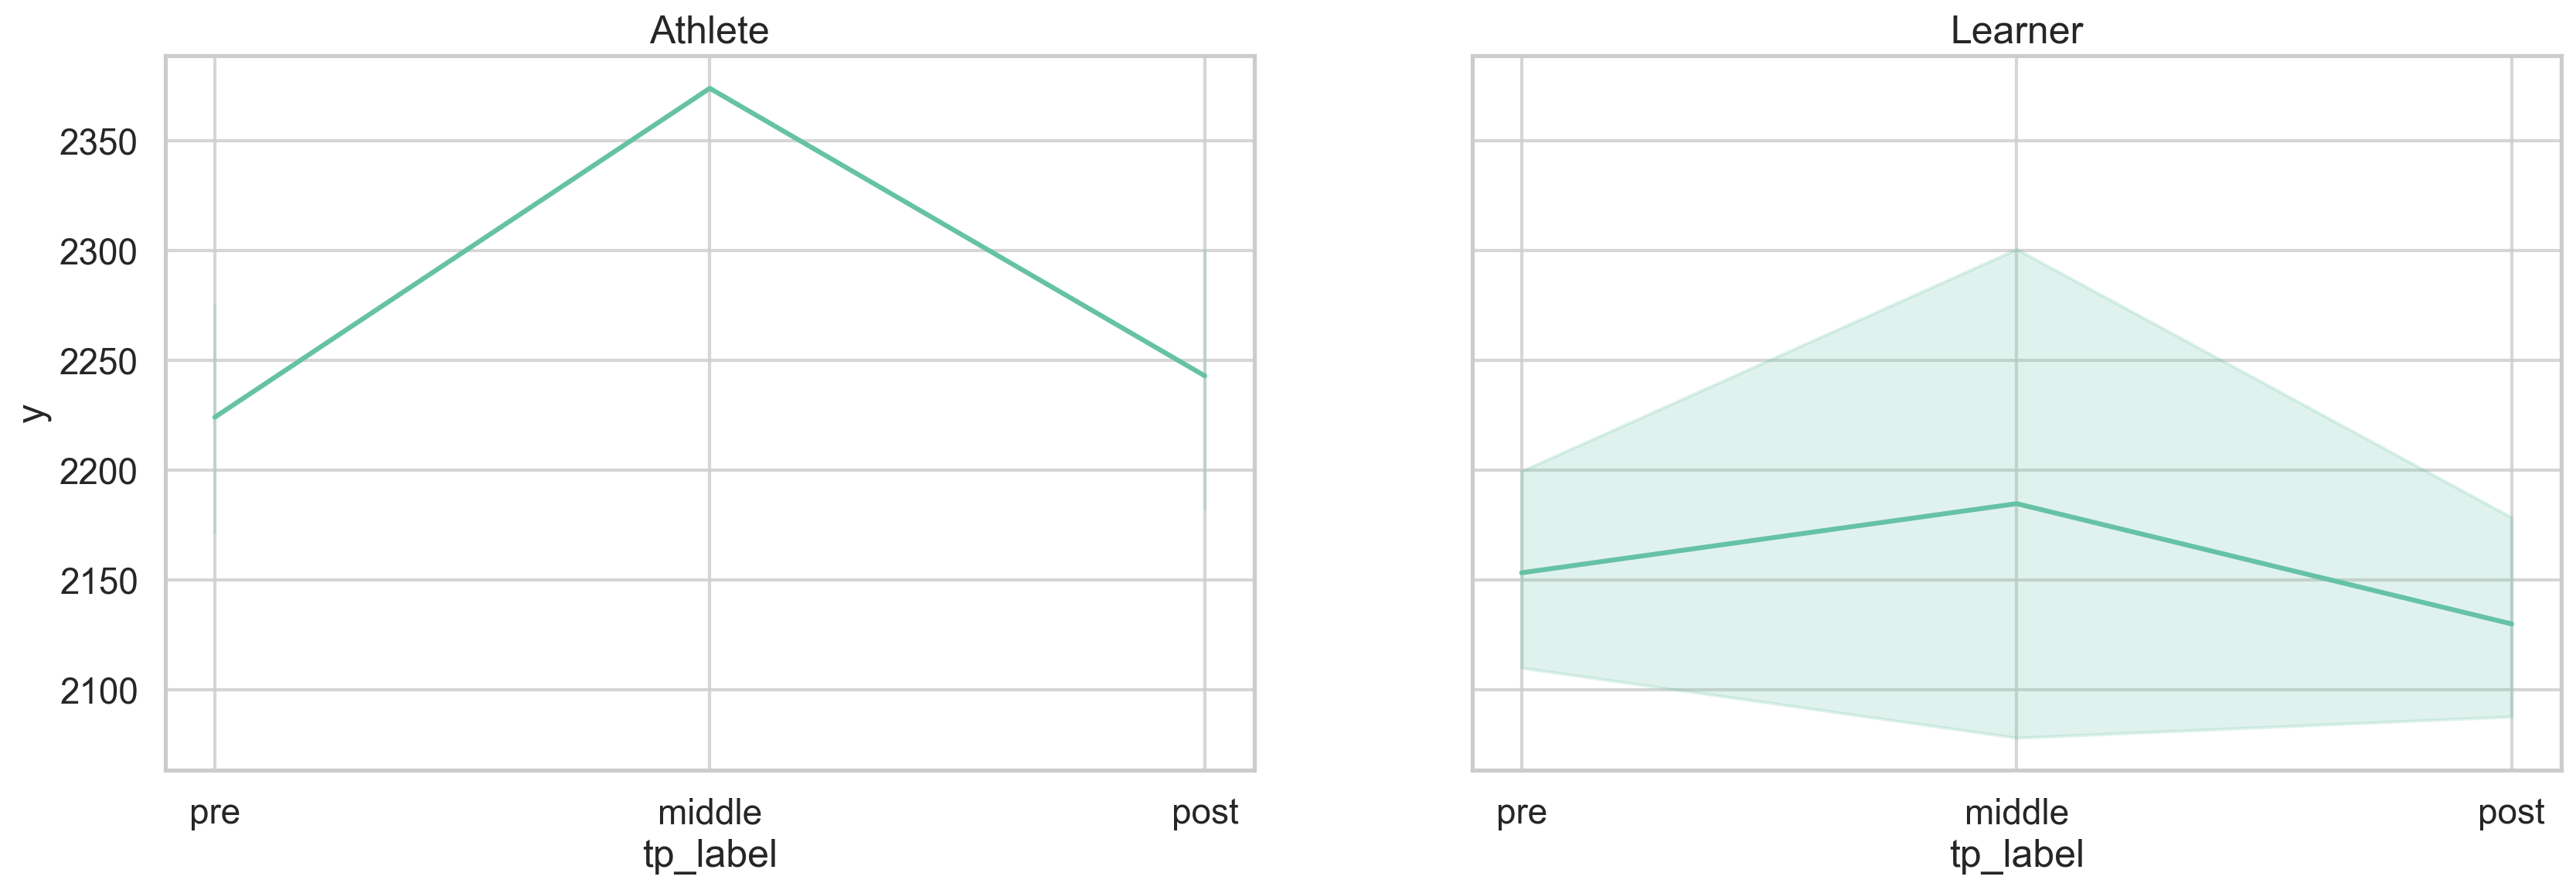

In [278]:
# 2) Keep subjects that have BOTH a pre and a post
# has_both = d.groupby("subject_code")["tp_label"].transform(
#     lambda s: {"pre", "post"}.issubset(set(s))
# )
# d = d[has_both].copy()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(20,6), sharex=True, sharey=True)

for ax,condition in zip(axes, ["Athlete", "Learner"]):
    ax = sns.lineplot(d[d["condition"] == condition], x="tp_label", y="y", ax=ax,
                    #   hue="subject_code", legend=False
                      )
    ax.set_title(condition)

In [326]:
vis_config = Fig1Config()

# cmaps = config.get_colormaps()
# cmap = cmaps["weighted"]
vis_config.COLORMAP = "coolwarm"

vis_config.VMIN = -3
vis_config.VMAX = 3
plotter = BrainPlotter(vis_config)

2025-08-24 15:55:19.223 | INFO     | athletes_brain.fig1.brain_visualization:plot_single_metric:276 - Creating brain plots for factor_interaction
2025-08-24 15:55:19.223 | INFO     | athletes_brain.fig1.brain_visualization:prepare_value_maps:57 - Preparing value maps for factor_interaction_z
2025-08-24 15:55:19.243 | INFO     | athletes_brain.fig1.brain_visualization:prepare_value_maps:97 - Prepared maps with 200 LH, 200 RH, and 54 subcortical regions
2025-08-24 15:55:19.243 | INFO     | athletes_brain.fig1.brain_visualization:plot_cortical_surface:121 - Creating cortical surface plots
2025-08-24 15:55:19.255 | INFO     | athletes_brain.fig1.brain_visualization:plot_cortical_surface:143 - Plotting left hemisphere
2025-08-24 15:55:20.129 | INFO     | athletes_brain.fig1.brain_visualization:plot_cortical_surface:177 - Saved left hemisphere plot to /media/storage/phd/athletes_brain/figures/learners/left_factor_interaction.png
2025-08-24 15:55:20.130 | INFO     | athletes_brain.fig1.brain_

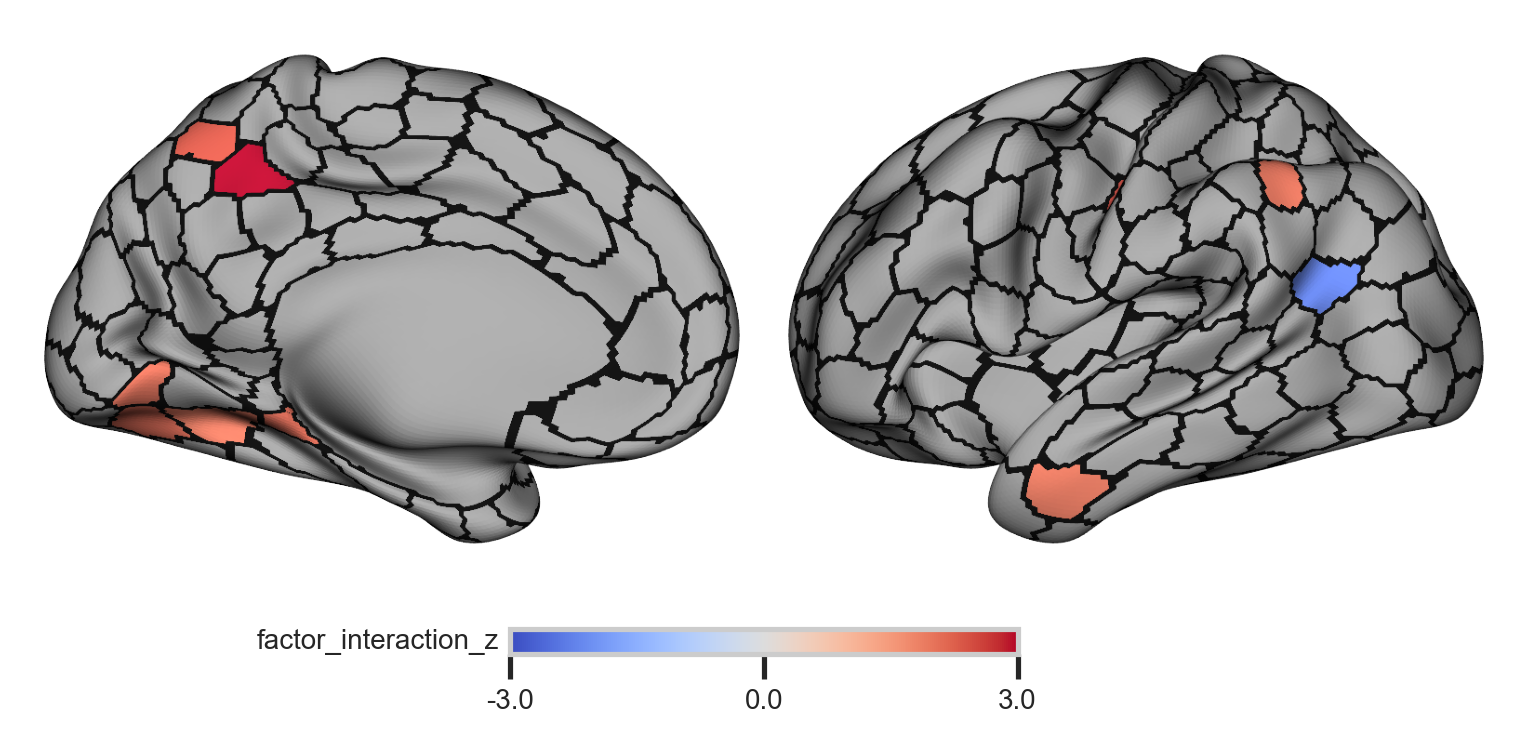

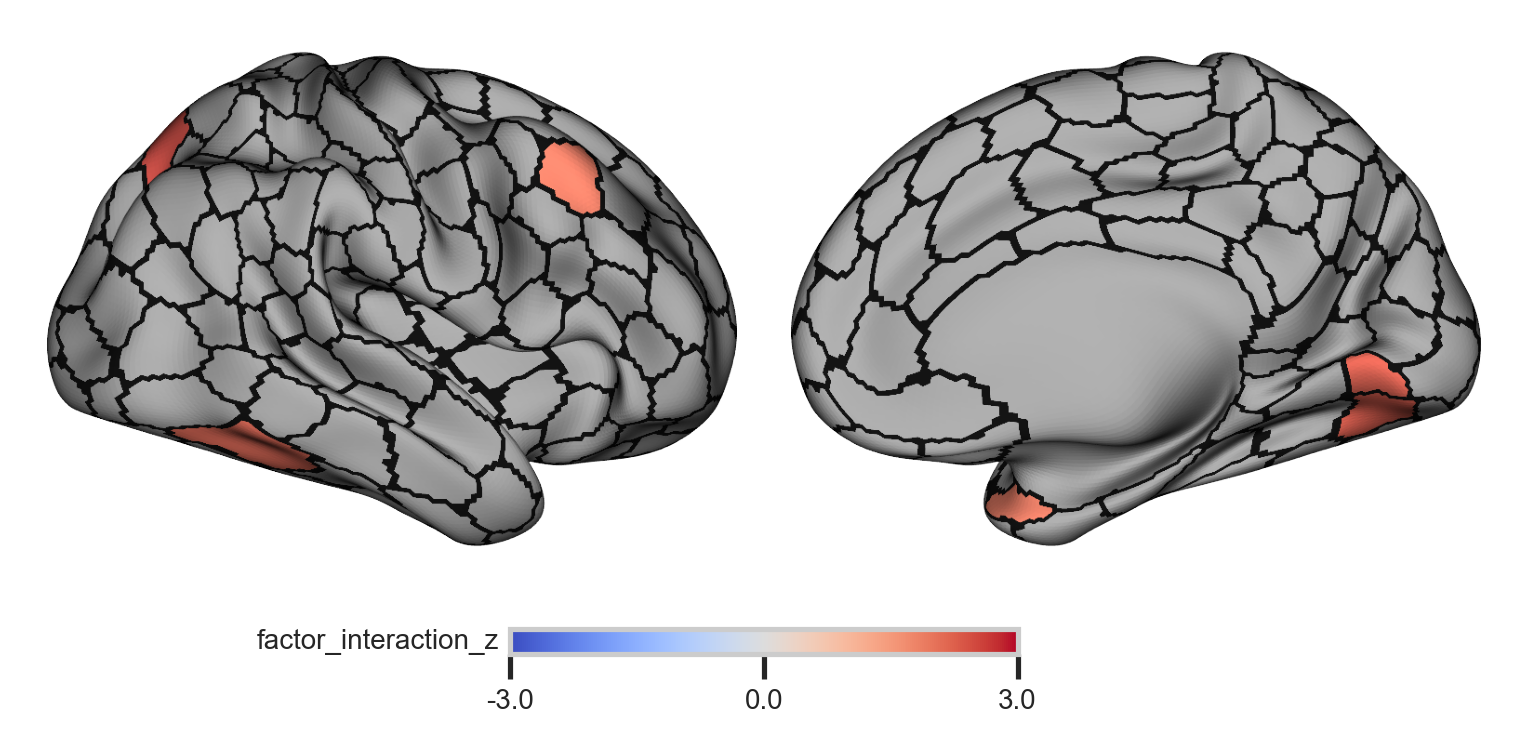

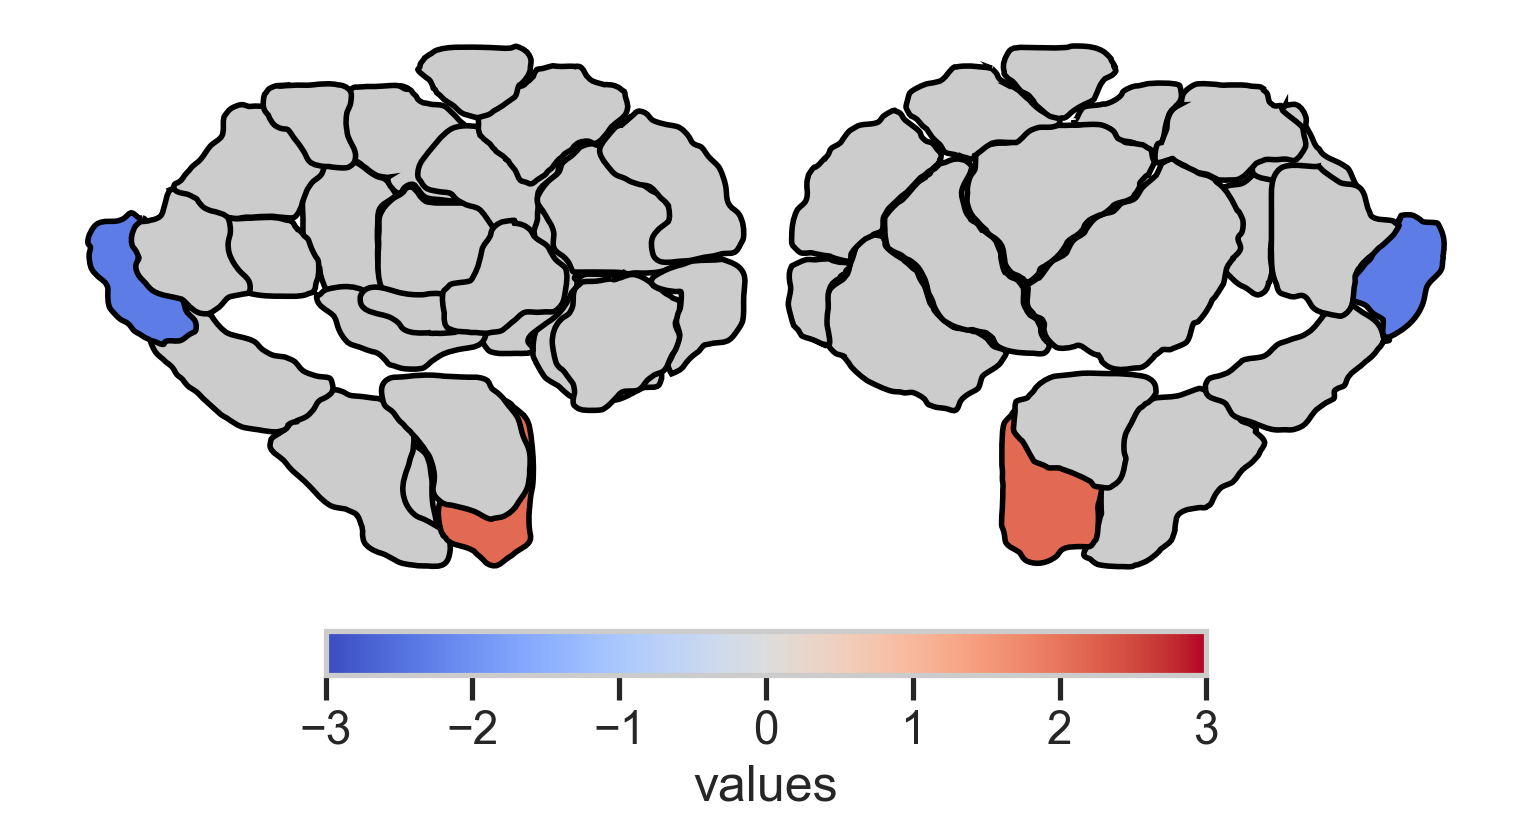

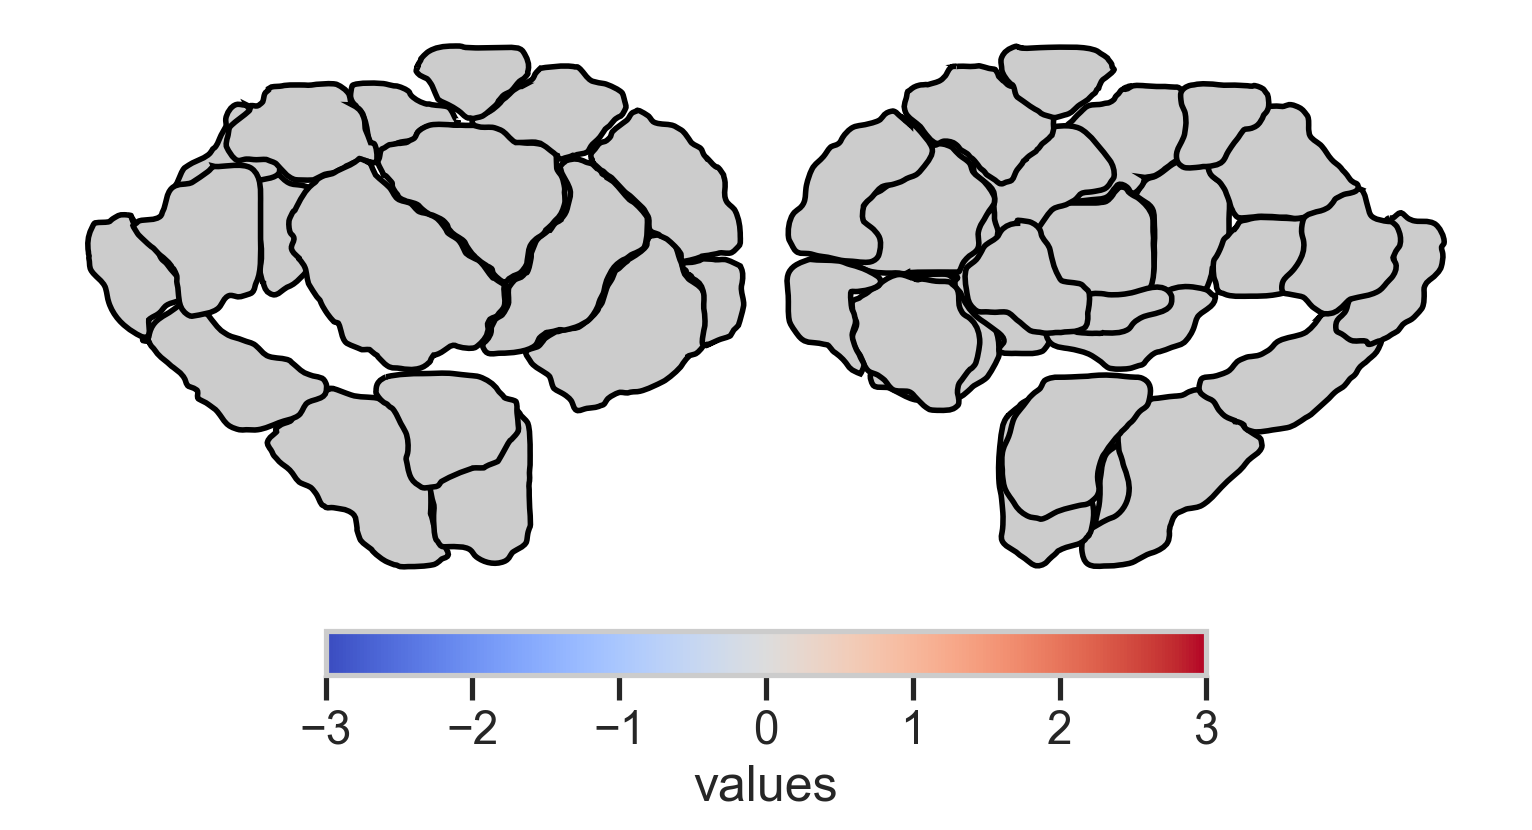

In [328]:

effect = "factor_interaction"
is_learner = effect.startswith("L") 

plotter.plot_single_metric(
    results_df=stats,
    metric_key=effect,
    output_dir=output_dir,
    p_column=f"{effect}_p" if not is_learner else effect.replace("beta",'p'),
    value_column=f"{effect}_z" if not is_learner else effect.replace("beta",'z')
)